In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2022-07-16 21:26:19.839048: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
print(X_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

In [4]:
print(X_train.min())
print(X_train.max())

0
255


In [5]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [6]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

In [7]:
def find_best_learning_rate(
    X_train, 
    X_val, 
    y_train, 
    y_val, 
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      X_train,
      y_train,
      epochs=1,
      steps_per_epoch=n_steps,
      validation_data=(X_val, y_val),
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 15.
    return best_learning_rate

In [8]:
def build_model(input_shape=None, output_shape=10, dropout=False, local_response_normalization=False, learning_rate=1e-3, compile=True):
    if not input_shape:
        input_shape = (28, 28, 1)
    
    model = keras.models.Sequential()
    
    # convolutional layers
    model.add(keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2)))
    if local_response_normalization:
        model.add(keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(keras.layers.Conv2D(32, (1, 1), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D((2, 2)))
    model.add(keras.layers.Conv2D(32, (1, 1), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    
    # dense layers
    model.add(keras.layers.Flatten())
    if dropout:
        model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(64, activation="relu"))
    if dropout:
        model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(output_shape))
                  
    if compile:
        model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=["accuracy"],
        )
    
    return model

In [9]:
def train_model(
    X_train, 
    X_val, 
    y_train, 
    y_val, 
    name, 
    compiled_model, 
    callbacks=None,
    n_epochs=500,
    batch_size=32,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f"{name}_model.h5", save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    tensorboard_cb = get_tensorboard_cb()
    
    history = compiled_model.fit(
      X_train,
      y_train,
      epochs=n_epochs,
      batch_size=batch_size,
      validation_data=(X_val, y_val),
      callbacks=callbacks + [checkpoint_cb, early_stopping_cb, tensorboard_cb],
    )

In [10]:
def get_tensorboard_cb():
    base_dir = os.path.join(os.curdir, ".tflogs")
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return keras.callbacks.TensorBoard(run_dir)    

In [11]:
model = build_model(learning_rate=1e-5)

2022-07-16 21:26:21.632719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 21:26:22.060073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        1056      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          2

2022-07-16 21:26:23.444820: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-16 21:26:24.060068: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-16 21:26:24.061188: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-16 21:26:24.061226: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-16 21:26:24.062888: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-16 21:26:24.062993: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  1/500 [..............................] - ETA: 18:20 - loss: 2.3078 - accuracy: 0.0636

2022-07-16 21:26:24.597451: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 8s 11ms/step - loss: 1.0339 - accuracy: 0.6692 - val_loss: 2.3098 - val_accuracy: 0.1026


0.002420520782470703

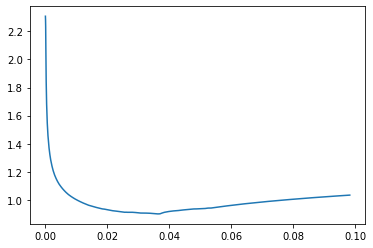

In [13]:
best_learning_rate = find_best_learning_rate(X_train, X_val, y_train, y_val, model)
best_learning_rate

In [14]:
model = build_model(learning_rate=best_learning_rate)
train_model(X_train, X_val, y_train, y_val, "basic_convolution", model)

Epoch 1/500
1719/1719 [==============================] - 15s 8ms/step - loss: 0.1196 - accuracy: 0.9621 - val_loss: 0.0547 - val_accuracy: 0.9832
Epoch 2/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0510 - accuracy: 0.9841 - val_loss: 0.0843 - val_accuracy: 0.9742
Epoch 3/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.0638 - val_accuracy: 0.9818
Epoch 4/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.0492 - val_accuracy: 0.9858
Epoch 5/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0286 - accuracy: 0.9915 - val_loss: 0.0582 - val_accuracy: 0.9858
Epoch 6/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0443 - val_accuracy: 0.9862
Epoch 7/500
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0581 -

500/500 [==============================] - 6s 11ms/step - loss: 1.1507 - accuracy: 0.6171 - val_loss: 2.3230 - val_accuracy: 0.1040


0.0022485824922720593

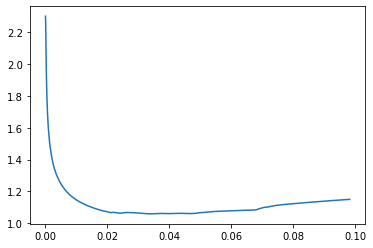

In [15]:
model = build_model(learning_rate=1e-5, dropout=True)
best_learning_rate = find_best_learning_rate(X_train, X_val, y_train, y_val, model)
best_learning_rate

In [16]:
model = build_model(learning_rate=best_learning_rate, dropout=True)
train_model(X_train, X_val, y_train, y_val, "basic_convolution_dropout", model)

Epoch 1/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2162 - accuracy: 0.9352 - val_loss: 0.0670 - val_accuracy: 0.9808
Epoch 2/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0994 - accuracy: 0.9724 - val_loss: 0.0515 - val_accuracy: 0.9830
Epoch 3/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0823 - accuracy: 0.9771 - val_loss: 0.0597 - val_accuracy: 0.9814
Epoch 4/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0691 - accuracy: 0.9800 - val_loss: 0.0522 - val_accuracy: 0.9854
Epoch 5/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0642 - accuracy: 0.9823 - val_loss: 0.0494 - val_accuracy: 0.9860
Epoch 6/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0617 - accuracy: 0.9825 - val_loss: 0.0493 - val_accuracy: 0.9874
Epoch 7/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0570 - accuracy: 0.9838 - val_loss: 0.0475 -

500/500 [==============================] - 6s 11ms/step - loss: 1.2008 - accuracy: 0.6144 - val_loss: 2.3323 - val_accuracy: 0.0972


0.003250190615653992

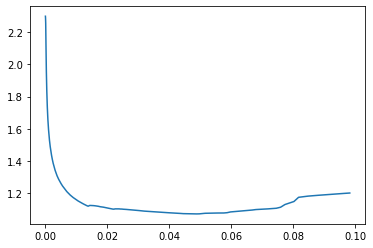

In [17]:
model = build_model(learning_rate=1e-5, dropout=True, local_response_normalization=True)
best_learning_rate = find_best_learning_rate(X_train, X_val, y_train, y_val, model)
best_learning_rate

In [20]:
# 2e-3 is better than 3e-3, which never gets to validation accuracy over 99%
model = build_model(learning_rate=2e-3, dropout=True, local_response_normalization=True)
train_model(X_train, X_val, y_train, y_val, "basic_convolution_dropout_lrn", model)

Epoch 1/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2148 - accuracy: 0.9348 - val_loss: 0.0649 - val_accuracy: 0.9814
Epoch 2/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0961 - accuracy: 0.9726 - val_loss: 0.0431 - val_accuracy: 0.9870
Epoch 3/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0786 - accuracy: 0.9778 - val_loss: 0.0495 - val_accuracy: 0.9852
Epoch 4/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0680 - accuracy: 0.9808 - val_loss: 0.0398 - val_accuracy: 0.9886
Epoch 5/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0595 - accuracy: 0.9833 - val_loss: 0.0396 - val_accuracy: 0.9886
Epoch 6/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.0424 - val_accuracy: 0.9888
Epoch 7/500
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0532 - accuracy: 0.9848 - val_loss: 0.0407 -

In [21]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0311 - accuracy: 0.9902


[0.031107360497117043, 0.9901999831199646]